In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.patches
import squarify
import os
from matplotlib.collections import PatchCollection
from common import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def st_to_str(st):
    return '%.1f' % st

all_st = np.arange(0.1, 1.0, 0.1)
all_st_str = map(st_to_str, all_st)
# all_st = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

def read_groups_size(path):
    groups = []
    if os.path.exists(path):
        with open(path, 'r') as f:
            f.readline() # Ignore dataset info
            from_length, to_length = map(int, f.readline().strip().split(' '))
            f.readline() # Ignore distance info
            for l in range(from_length, to_length):
                count = int(f.readline())
                group_sizes = map(int, f.readline().strip().split(' '))
                for s in group_sizes:
                    groups.append({'length': l, 'size': s})
    return pd.DataFrame(groups)


def load_groups_of_all_datasets(st):
    prefix = '../../datasets/UCR'
    groups = {}
    for d in all_dataset_metadata:
        file_name = d['file_name']
        name = d['name']
        size = d['size']
        g = read_groups_size('%s/%s/%s_DATA_GROUPS_SIZE_%s'%(prefix, file_name, file_name, st))
        groups[file_name] = {
            'group_size': g,
            'name': name,
            'size': size
        }

    return groups


In [489]:
all_dataset_groups = {}
for st in all_st_str:
    all_dataset_groups[st] = load_groups_of_all_datasets(st)


# Group Heat Maps

In [490]:
def plot_groups(ax, groups_df, count_limit, padded=False):
    if groups_df.empty:
        return None
    # these values define the coordinate system for the returned rectangles
    # the values will range from x to x + width and y to y + height
    x = 0.
    y = 0.
    width = 250
    height = width
    
    groups_df = groups_df.sort_values('size', ascending=False)
    values = groups_df['size'].values
    cumsum_val = np.cumsum(values)
    cutoff = min(max(np.argmax(cumsum_val >= count_limit), 1), 500)
    values = values[:cutoff]
    
    colors = groups_df['length'].values
    colors = colors[:cutoff]

    # the sum of the values must equal the total area to be laid out
    # i.e., sum(values) == width * height
    values = squarify.normalize_sizes(values, width, height)

    if padded:
        rects = squarify.padded_squarify(values, x, y, width, height)
    else:
        rects = squarify.squarify(values, x, y, width, height)

    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    
    def to_patch(rect):
        return matplotlib.patches.Rectangle((rect['x'], rect['y']), rect['dx'], rect['dy'])
    
    patches = map(to_patch, rects)
    collection = PatchCollection(patches, cmap=matplotlib.cm.plasma, alpha=0.9)
    collection.set_array(colors)
    ax.add_collection(collection)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return collection


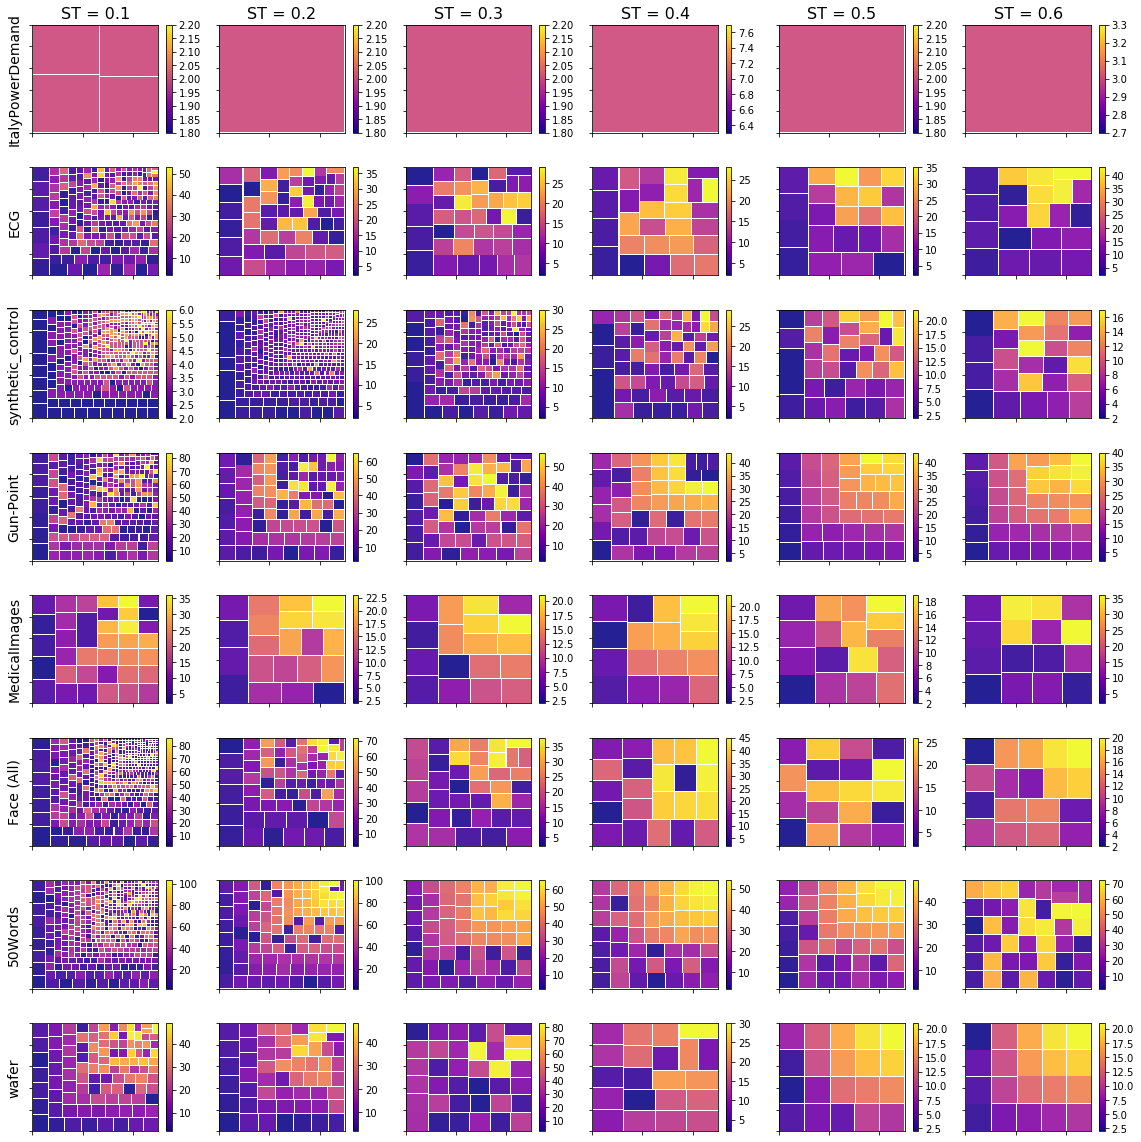

In [492]:
fig, axes = plt.subplots(8, 6, figsize=(16, 16))

selected_st = map(st_to_str, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

for i, file_name in enumerate(sorted_name_by_size):
    for j, st in enumerate(selected_st):
        group_size_df = all_dataset_groups[st][file_name]['group_size']
        size = all_dataset_groups[st][file_name]['size']
        name = all_dataset_groups[st][file_name]['name']
        if i == 0:
            axes[i][j].set_title('ST = ' + st, fontsize=16)
            
        if j == 0:
            axes[i][j].set_ylabel(name, fontsize=14)
        
        ax = axes[i][j]
        col = plot_groups(ax, group_size_df, 0.25*size, padded=True)

        if col is not None:
            fig.colorbar(col, ax=ax)
    
#     fig.suptitle('ST = %.1f' % st, fontsize=15)
plt.tight_layout()
#     fig.subplots_adjust(top=0.85)
plt.savefig('group_heat_map_all.eps')

# Construction time, size, and compression ratio

In [493]:
raw_data = np.array([2.91,4.7,0.51,2.2,0.13,1.9,0.06,1.8,0.03,1.8,0.02,1.8,0.02,1.8,0.02,1.8,0.01,1.8,
8.82,46.4,1.91,10,0.52,3.9,0.16,2.9,0.08,2.7,0.06,2.7,0.04,2.7,0.03,2.6,0.04,2.6,
64.06,106,35.95,69.5,12.63,25.5,3.6,9.9,0.56,4,0.13,3.5,0.06,3.4,0.04,3.4,0.03,3.4,
18.02,69.8,3.11,18.2,1.46,13.1,0.72,11.5,0.45,11,0.34,10.8,0.32,10.8,0.28,10.7,0.22,10.6,
158.4,111,15.29,31.4,2.72,25.4,1,24.7,0.49,24.6,0.4,24.6,0.36,24.6,0.31,24.6,0.29,24.6,
3328,838.2,85.76,113.4,5.82,104.7,1.91,104.4,1.48,104.4,1.31,104.4,1.33,104.4,1.3,104.4,1.28,104.4,
2745,1945.6,355.2,352,48.08,140.2,12.67,120.6,4.66,118,2.77,117.4,2.57,117.3,2.53,117.3,2.42,117.3,
3952,783.1,256.6,559.5,24.31,552.6,10.65,552.5,8.62,552.4,8.19,552.4,8.17,552.4,8.14,552.4,7.41,552.4])
raw_data = raw_data.reshape((8,-1))

In [526]:
group_time = raw_data[:, range(0, 18, 2)]
group_size = raw_data[:, range(1, 19, 2)]

group_compression = {}
for st in all_st:
    key = '%.1f' % st
    group_compression[st] = []
    for d in sorted_name_by_size:
        ds = all_dataset_groups[key][d]
        number_of_groups = ds['group_size'].shape[0]
        avg_group_size = ds['group_size']['size'].mean()
        compression = np.float(number_of_groups + avg_group_size) / ds['size']
        group_compression[st].append(compression)

ds_index = sorted_name_by_size

group_time_df = pd.DataFrame(group_time, index=index, columns=all_st)
group_size_df = pd.DataFrame(group_size, index=index, columns=all_st)
group_compression_df = (1 - pd.DataFrame(group_compression, index=index)) * 100


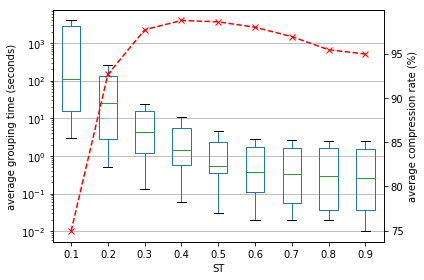

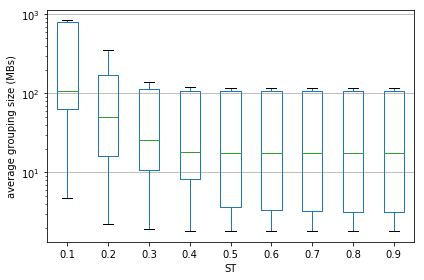

In [527]:
fig, ax_time = plt.subplots(1)
ax_compress = ax_time.twinx()
ax_time.set_yscale('log')
ax_time.set_ylabel('average grouping time (seconds)')
ax_time.set_xlabel('ST')
group_time_df.boxplot(ax=ax_time, positions=all_st, grid='off', sym='', widths=0.05)

ax_compress.set_ylabel('average compression rate (%)')
group_compression_df.mean(axis=0).plot(ax=ax_compress, marker='x', linestyle='--', color='red')
ax_time.yaxis.grid('on')
ax_time.set_xlim(0.05, 0.95)
fig.tight_layout()
fig.savefig('group_time_and_compression.eps')

fig, ax_size = plt.subplots(1)
ax_size.set_yscale('log')
ax_size.set_ylabel('average grouping size (MBs)')
ax_size.set_xlabel('ST')
group_size_df.boxplot(ax=ax_size, positions=all_st, grid='off', sym='', widths=0.05)
ax_size.set_xlim(0.05, 0.95)
ax_size.yaxis.grid('on')
fig.tight_layout()
fig.savefig('group_size.eps')


In [ ]:
print group_compression_df